In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

# Read Captions File

In [7]:
# Reading the Description file

with open("./flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [8]:
captions = captions.split("\n")[:-1]

In [10]:
len(captions)

40460

In [25]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    # if key is not present, initialise it with empty list.
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [29]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Data Cleaning

In [30]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 2 """ 

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [31]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [32]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [33]:
#  clean descriptions

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [34]:
# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [ ]:
##############
# Dont' run this cell
#############

#  reading description file





# f = open("storage/descriptions.txt", 'r')
# descriptions = f.read()
# f.close()

# json_acceptable_string = descriptions.replace("'", "\"")
# descriptions = json.loads(json_acceptable_string)

In [35]:
# creating the unique vocabulary 

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [37]:
#  ALL words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('All Words Size: %d' % len(all_vocab))
print(all_vocab[:15])

All Words Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [38]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [39]:
len(all_vocab)

1845

# Loading Training Testing Data

In [41]:
# TrainImagesFile
f = open("flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [47]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [50]:
# TestImagesFile
f = open("flicker8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [51]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [57]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

# Data Preprocessing - Images

In [61]:
#"""In this section, we will load our images and do some processing so that we can feed it in our network."""

In [63]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

In [65]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [70]:
images = "./flicker8k-dataset/Flickr8k_Dataset/"

In [71]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = img.reshape(1,224,224,3)
    img = preprocess_input(img)
    return img

In [72]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [73]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):
    
    img = "./flicker8k-dataset/Flickr8k_Dataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400


KeyboardInterrupt: 

In [ ]:
# Save the bottleneck train encoding to disk

with open("./storage/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# TEST IMAGES

start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "./flicker8k-dataset/Flickr8k_Dataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck test ecoding to disk

with open("./storage/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [74]:
# Load the train images encoding from disk

with open("./storage/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [75]:
# Load the test images encoding from disk

with open("./storage/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [78]:
encoding_test['3385593926_d3e9c21170.jpg'].shape

(2048,)

In [81]:
encoding_train['2513260012_03d33305cf.jpg'].shape

(2048,)

# Data Preprocessing - Captions

In [82]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

In [86]:
#  need to add these 2 words as well (explicitly)
 
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [88]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [89]:
# Max length kitni ho sakti hai? Caption ki
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


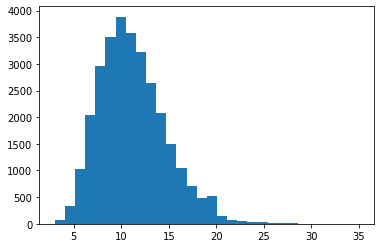

In [94]:
a=plt.hist(all_captions_len, bins=30)

In [95]:
with open("./storage/word_to_idx.pkl", "wb") as w2i:
    pickle.dump(word_to_idx, w2i)
    
with open("./storage/idx_to_word.pkl", "wb") as i2w:
    pickle.dump(idx_to_word, i2w)

# Data Preparation using Generator Function

In [96]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [122]:
my_gen = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)

In [128]:
X, y = next(my_gen)

In [131]:
X[0].shape

(150, 2048)

In [133]:
X[1].shape

(150, 35)

In [134]:
y.shape

(150, 1848)

# Word Embedding

In [97]:
f = open("./GloVE/glove.6B.50d.txt", encoding='utf8')

In [98]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

## Converting words into vectors  Directly - (Embedding Layer Output)

In [99]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [100]:
embedding_output.shape

(1848, 50)

# Model Architecture

In [106]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [109]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [110]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [111]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
__________________________________________________________________________________________________
dropout_4 

In [112]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [113]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

# Train Our Model

In [115]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [116]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
  86/2000 [>.............................] - ETA: 14:33 - loss: 5.6890

KeyboardInterrupt: 

In [117]:
model = load_model("./model_weights/model_9.h5")

# Predictions

In [118]:
def predict_caption(photo):
    """
    photo => encoding of that image (2048,)
    """
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

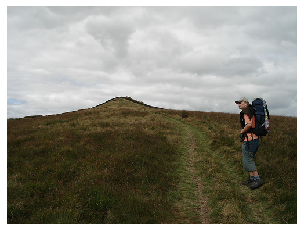

man in hat and black shirt is standing on top of rock overlooking valley


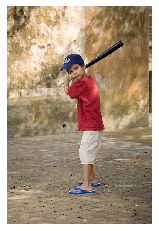

boy in white shirt is running on the beach


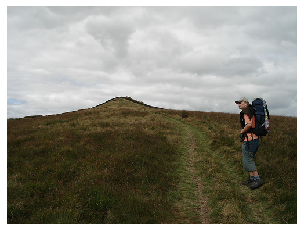

man in hat and black shirt is standing on top of rock overlooking valley


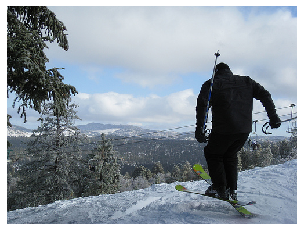

man is standing on top of mountain


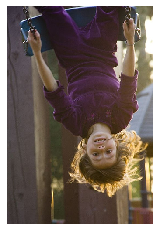

little girl in white shirt is sitting on the floor


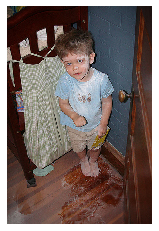

little boy in pajamas is sitting on the floor with toys


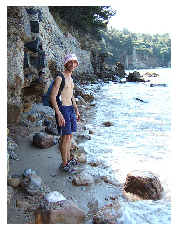

woman in blue shorts is standing on the beach


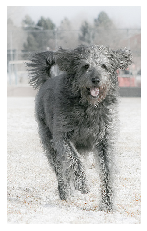

dog is running on the beach


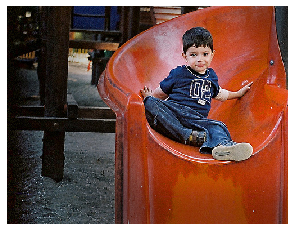

child in red shirt is sitting on the stomach of slide


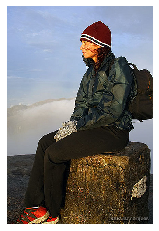

man in grey shirt and jeans is standing on top of mountain


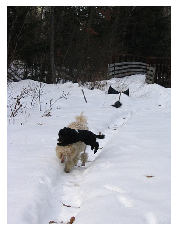

dog runs through snow


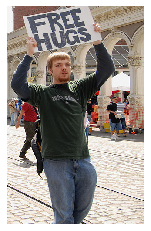

man in blue shirt and jeans is standing on the street


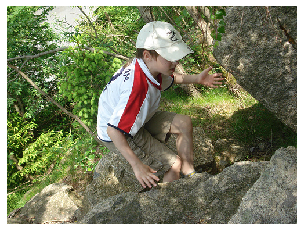

man in red shirt is standing on rock face


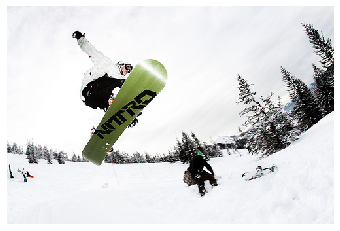

snowboarder in the air over the snow


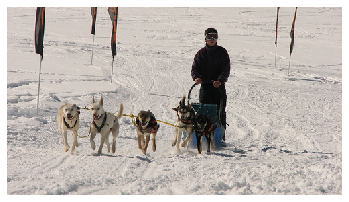

two people are walking on the beach


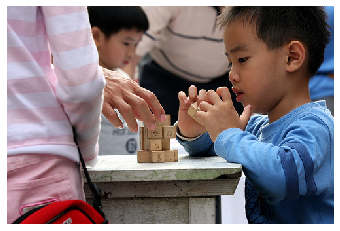

woman with glasses and woman in black


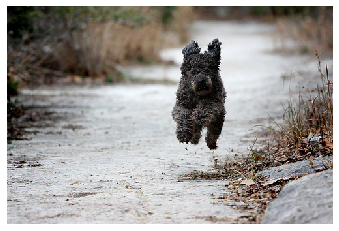

dog running in the snow


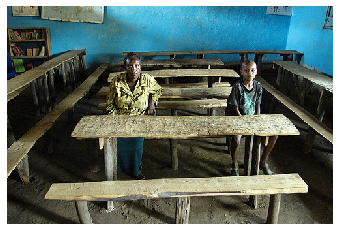

man is sitting on bench with his feet on her feet


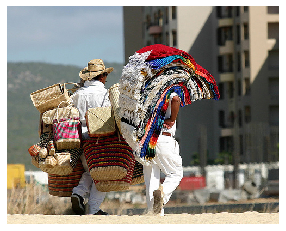

man in red shirt is standing on the beach


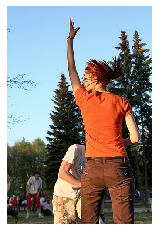

boy in white shirt is walking on the grass


In [121]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)